W ramach zajęć zapoznamy się z podstawowymi próbkującymi metodami sterowania. Istot-
nym elementem tych metod jest model który pozwala na ocenę sekwencji akcji przed ich
podaniem na elementy wykonawcze robota. Funkcją określającą skuteczność naszego algo-
rytmu jest funkcja nagrody ”reward” który jest zdefiniowana wewnątrz zaproponowanych
środowisk. Celem algorytmu sterującego jest jego maksymalizacja.
1 Wahadło
1. Zapoznaj się z środowiskiem Pendulum będzie ono podstawą do przetesowania kolej-
nych metod sterowania.
2. Spróbuj ustawić stan początkowy środowiska na zadaną wartość, np. [3.14, 0.0].
3. Zrealizuj sterownik PD w celu stabilizacji wahadła w konfiguracji pionowej skierowanej
w górę, zakładając że stan początkowy to [0.1, 0.5] następnie przetestuj czy możliwe
jest podniesienie wahadła ze stanu początkowego [3.1, 0.]
4. Prawdopodobnie było to niemożliwe, napisz sterownik który najpierw steruje energią
do zadanego poziomu a potem przełącza się na PD w okolicy góry. Pomocna może się
okazać praca.
5. Pomimo, że zadanie nie jest przesadnie skomplikowane to jego rozwiązanie wyma-
gało wykorzystania dwóch regulatorów, z czego jednego dość specyficznego. Nie jest
też oczywiste jak zaproponowane podejście ma się do funkcji nagrody zwracanej przez
środowisko. Spróbujmy podejść do tego problemu w inny, bardziej ogólny sposób. Spró-
bujemy napisać najprostszy algorytm oparty o model próbkujący przestrzeń sterowań,
którego zadaniem będzie maksymalizacja nagrody. Jego działanie można przedstawić
w postaci programu:
• ustaw aktualny stan jako stan początkowy, wygeneruj losową sekwencje sterowań
o zadanej długości
• wykorzystując metodę step środowiska oceń skumulowaną nagrodę całej trajek-
torii symulowanych stanów i sterowań
1
• powtarzaj n-razy krok 1, 2
• zwróć pierwszą akcje sekwencji o największej nagrodzie
6. Dla opracowanego algorytmy przygotuj wykres [heatmap] pokazujący skumulowaną
nagrodą dla całego epizodu dla różnych wartości ilości rolloutów: n oraz ich długości.
7. To była prawdopodobnie najbardziej toporna metoda sterowania próbkującego opar-
tego o model jaką można sobie wyobrazić. W dalszej części zajęć zmodyfikujemy ją
trochę, tak aby otrzymać algorytm MPPI i uzyskać lepszą jakość sterowania.
Poniżej przedstawiony jest algorytm pojedynczego wywołania algorytmu sterowania
MPPI. W naszym zastosowaniu, aby nie tracić cennych obliczeń, będziemy przecho-
wywać sekwencję sterowań u∗ i podawać ją jako początkową sekwencję sterowań u0 do
Algorytmu 1. Podnato, aby wziąć pod uwagę upływ czasu, przesuniemy sterowania w
podanej sekwencji o jedną próbkę, pomijając pierwszą i dodając na końcu sekwencji
zera.
Algorithm 1 Model Predictive Path Integral (MPPI) Control
1: Input: Aktualny stan x0, początkowa sekwencja sterowań u0, liczba trajektorii N , ho-
ryzont symulacji T , funkcja kosztu C, dynamika systemu f , kowariancja szumu Σ, mi-
nimalne i maksymalne dopuszczalne sterowania u, ¯u, temperatura λ
2: Output: Optymalna sekwencja sterowań u∗
3: for iteration k = 1, 2, . . . do
4: for each trajectory n = 1, 2, . . . , N do
5: Wylosuj perturbacje sterowań δun ∼ N (0, Σ)
6: Wygeneruj zaburzone sekwencje sterowań: un = uk + δun
7: Ogranicz zaburzone sterowania do dopuszczalnych zakresów ¯un = clamp(un, u, ¯u)
8: Oblicz efektywne zaburzenia ∆un = ¯un − uk
9: Wysymuluj trajektorię xn od stanu początkowego x0, używając dynamiki f i stero-
wań un
10: Oblicz koszt trajektorii Sn = ∑T −1
t=0 C(xn
t , un
t )
11: end for
12: Oblicz wagi wn = exp(−Sn/λ)
13: Znormalizuj wagi: ˜wn = wn
∑N
m=1 wm
14: Zmodyfikuj sekwencję sterowań: uk+1 = uk + ∑N
n=1 ˜wn∆un
15: end for
16: Return: u∗ = uk
8. Spróbuj wprowadzić zaburzenia do modelu i oceń odporność algorytmu na błędy mo-
delu.
9. Zmień środowisko z Pendulum na Hopper i zaobserwuj ogólność algorytmu MPPI.
Spróbuj zaimplementować MPPI tak, aby bez problemu można było podmienić środo-
wisko na inne.

In [22]:
import gymnasium as gym
from IPython import display
import matplotlib.pyplot as plt

In [39]:
def display_gym(env):
    plt.figure(1)
    plt.clf()
    plt.imshow(env.render())
    plt.axis('off')

    display.display(plt.gcf())
    display.clear_output(wait=True)

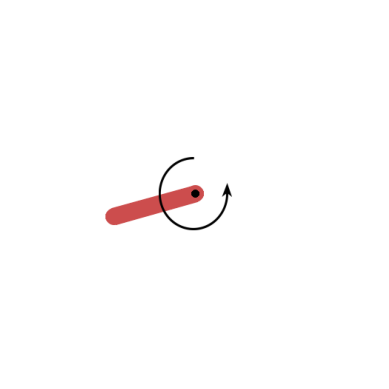

In [40]:
env = gym.make('Pendulum-v1', render_mode="rgb_array", g=9.81)
env.reset(seed=123, options={"low": 0.0, "high": 0.0})

for _ in range(100):
    display_gym(env)
    action = env.action_space.sample()
    env.step(action)